In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
# from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from scipy import stats
import pyhere


In [219]:
dir_data_raw = pyhere.here().resolve().joinpath("data", "raw")
dir_data_interim = pyhere.here().resolve().joinpath("data", "interim")
dir_data_external = pyhere.here().resolve().joinpath("data", "external")

In [220]:
csv_power_plants = pd.read_csv(dir_data_interim/"power_plants_with_generation_transformed.csv", index_col=[0])

In [221]:
df_transformed = pd.read_csv(dir_data_external/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])

In [222]:
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)

In [223]:
df_power_plants_raw = pd.read_csv(dir_data_raw/"global_power_plant_database.csv", usecols=['primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

In [224]:

index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

csv_power_plants.drop(index_set_to_delete, inplace = True)

# csv_power_plants.filter(like='other_fuel').columns

# csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])]

In [225]:
columns_to_combine = [
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")

primary_fuel_transformed
Other                       18859
Solar                       10664
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

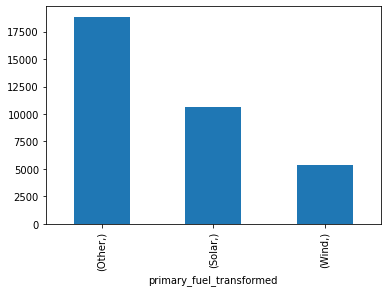

In [226]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [227]:
# df_transformed_combined = df_transformed_combined.loc[df_transformed_combined['generation_gwh_2013'].notna() & df_transformed_combined['generation_gwh_2014'].notna() & df_transformed_combined['generation_gwh_2015'].notna() & df_transformed_combined['generation_gwh_2016'].notna() & df_transformed_combined['generation_gwh_2017'].notna() & df_transformed_combined['generation_gwh_2018'].notna() & df_transformed_combined['generation_gwh_2019'].notna()]

primary_fuel_transformed
Other                       18859
Solar                       10664
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

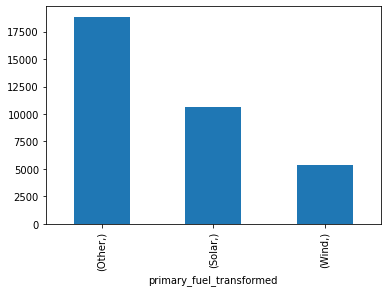

In [228]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [229]:
label_encoder = LabelEncoder()
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
df_transformed_combined = df_transformed_combined[df_transformed_combined['primary_fuel_transformed'].notna()]
df_transformed_combined['code_prim_fuel_transf'] = label_encoder.fit_transform(df_transformed_combined['primary_fuel_transformed'])


In [230]:
df_target_equivalent = df_transformed_combined[['primary_fuel_transformed', 'code_prim_fuel_transf']].drop_duplicates()
df_target_equivalent

,primary_fuel_transformed,code_prim_fuel_transf
index,,
0,Other,0
1,Solar,1
91,Wind,2


## Balancing the data

In [231]:
# index_rows_to_delete_other = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(4000).index
index_rows_to_delete_other = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(13500).index
# index_rows_to_delete = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 0].sample(9000).index
# index_rows_to_delete_wind = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 2].sample(100).index
index_rows_to_delete_solar = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 1].sample(5300).index
# index_rows_to_delete_solar = df_transformed_combined[df_transformed_combined['code_prim_fuel_transf'] == 1].sample(3000).index


In [232]:
df_transformed_combined.drop(index_rows_to_delete_other, axis = 0, inplace = True)
df_transformed_combined.drop(index_rows_to_delete_solar, axis = 0, inplace = True)
# df_transformed_combined.drop(index_rows_to_delete_wind, axis = 0, inplace = True)

<AxesSubplot:xlabel='primary_fuel_transformed'>

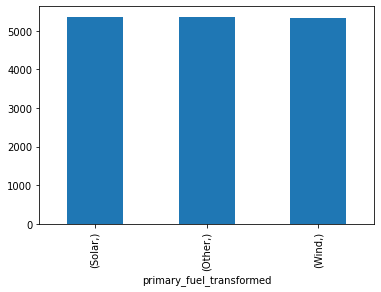

In [233]:
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [234]:
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
columns_to_drop = [
                        'capacity_mw',
                        'latitude',
                        'longitude',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
pre_X = df_transformed_combined.drop(columns=columns_to_drop)
pre_X.dropna(inplace = True)
X = pre_X.drop(columns=['code_prim_fuel_transf'])
y = pre_X['code_prim_fuel_transf']

In [235]:
y.value_counts()

1    5364
0    5359
2    5340
Name: code_prim_fuel_transf, dtype: int64

In [236]:
# sns.kdeplot(data=pre_X, x='winter_TQV_2009', hue='code_prim_fuel_transf', shade=True)

In [237]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [238]:
def get_accuracy(max_leaf_nodes, X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds_val)

    return accuracy

In [239]:
def get_accuracy_knn(n_neighbors, X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier(n_neighbors = n_neighbors)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds_val)

    return accuracy

In [240]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [241]:
# mi_scores = make_mi_scores(X, y)
# mi_scores[::3]

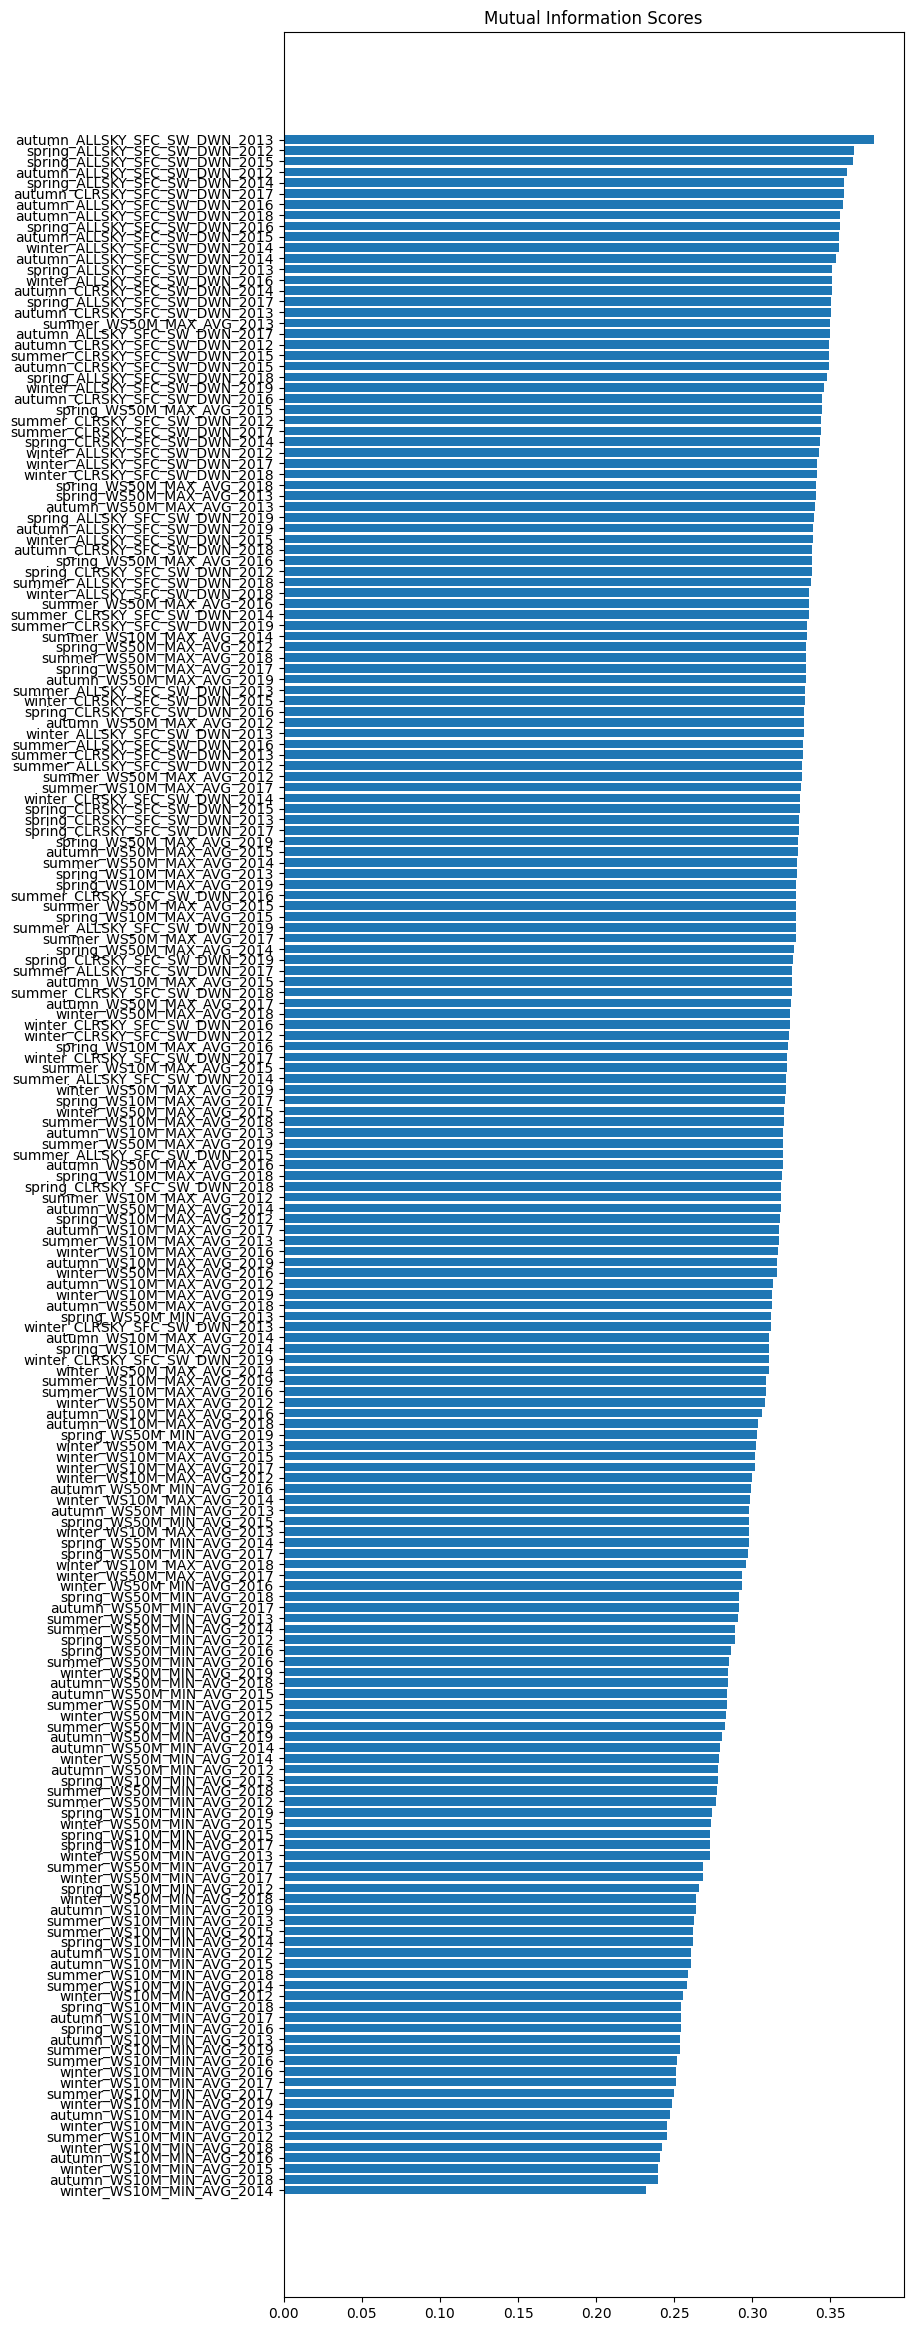

In [242]:
plt.figure(dpi=100, figsize=(8, 30))
plot_mi_scores(mi_scores)

In [243]:
 columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('autumn_CLRSKY_SFC_SW_DWN_2019')
 X = X.loc[:,~columns_delete]

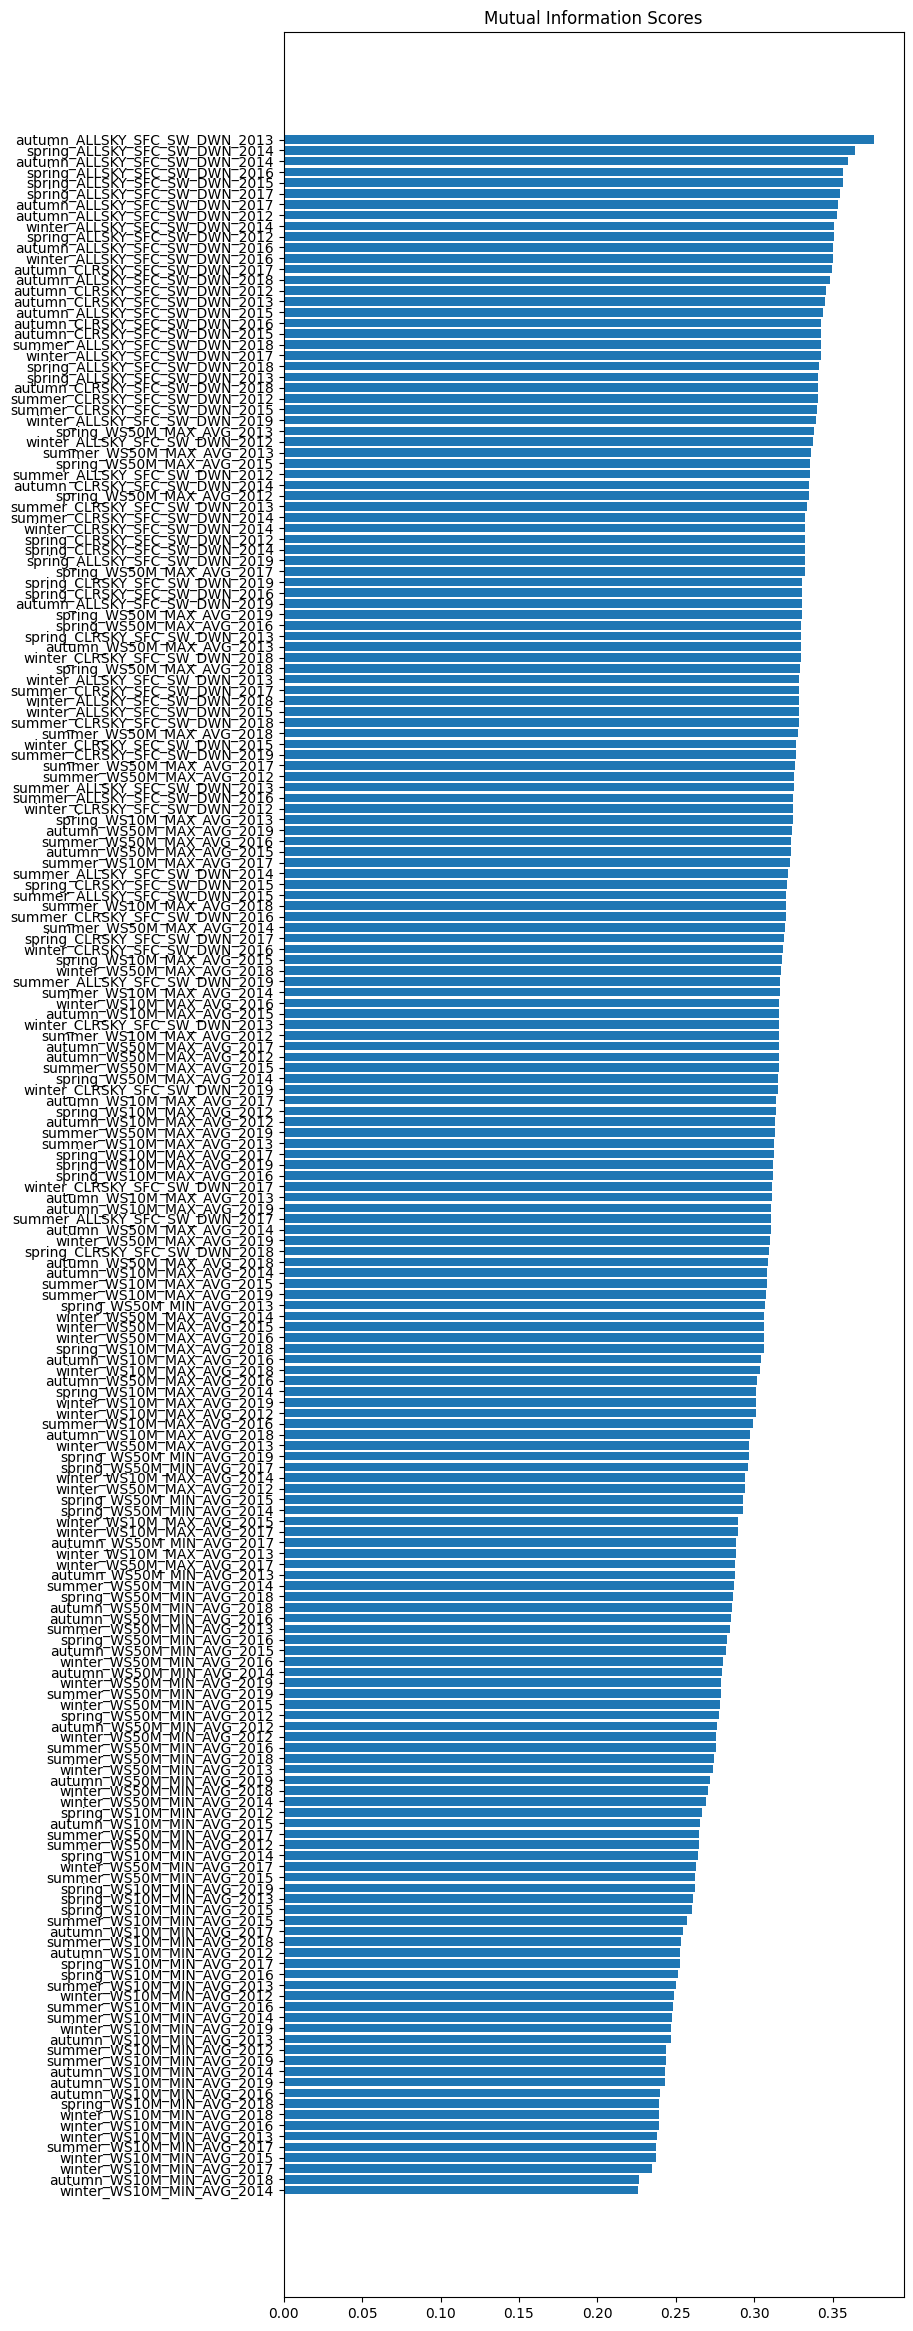

In [244]:
mi_scores = make_mi_scores(X, y)
plt.figure(dpi=100, figsize=(8, 30))
plot_mi_scores(mi_scores)

In [245]:
X.columns

Index(['autumn_ALLSKY_SFC_SW_DWN_2012', 'autumn_ALLSKY_SFC_SW_DWN_2013',
       'autumn_ALLSKY_SFC_SW_DWN_2014', 'autumn_ALLSKY_SFC_SW_DWN_2015',
       'autumn_ALLSKY_SFC_SW_DWN_2016', 'autumn_ALLSKY_SFC_SW_DWN_2017',
       'autumn_ALLSKY_SFC_SW_DWN_2018', 'autumn_ALLSKY_SFC_SW_DWN_2019',
       'autumn_CLRSKY_SFC_SW_DWN_2012', 'autumn_CLRSKY_SFC_SW_DWN_2013',
       ...
       'winter_WS50M_MAX_AVG_2018', 'winter_WS50M_MAX_AVG_2019',
       'winter_WS50M_MIN_AVG_2012', 'winter_WS50M_MIN_AVG_2013',
       'winter_WS50M_MIN_AVG_2014', 'winter_WS50M_MIN_AVG_2015',
       'winter_WS50M_MIN_AVG_2016', 'winter_WS50M_MIN_AVG_2017',
       'winter_WS50M_MIN_AVG_2018', 'winter_WS50M_MIN_AVG_2019'],
      dtype='object', length=191)

In [246]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2,random_state = 0)

## DECISION TREE CLASSIFIER

1200


<AxesSubplot:>

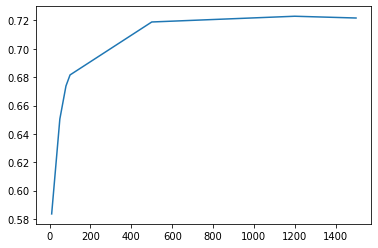

In [247]:
candidate_max_leaf_nodes = [10, 50, 80, 100, 500, 1200, 1500]
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


results = {node: get_accuracy(node, train_X, val_X, train_y, val_y) for node in candidate_max_leaf_nodes}
# results = {node: get_accuracy(node, train_X_scaled_pca, val_X_scaled_pca, train_y, val_y) for node in candidate_max_leaf_nodes}
# for node in candidate_max_leaf_nodes:
#     results[node] = get_accuracy(node, X_train, X_test, y_train, y_test)
# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = max(results, key=results.get)
print(best_tree_size)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [248]:
tree_model = DecisionTreeClassifier(max_leaf_nodes = best_tree_size, random_state=0)
tree_model.fit(train_X, train_y)

DecisionTreeClassifier(max_leaf_nodes=1200, random_state=0)

0.7230003112356054
[0.72019919 0.72486772 0.72860255 0.72073474 0.72042341]
Mean: 0.7229655249397393, Standard Deviation: 0.0033010835305823496


<AxesSubplot:>

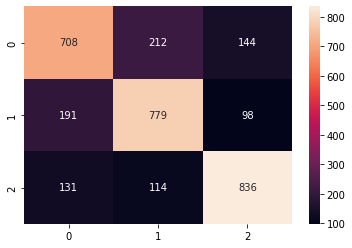

In [249]:
y_pred = tree_model.predict(val_X)
print(tree_model.score(val_X, val_y))
results_cvs = cross_val_score(tree_model, X, y, cv=StratifiedKFold(shuffle = True))
print(results_cvs)
print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# RANDOM FOREST CLASSIFIER

In [250]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [50, 100, 500]
# Minimum numbers of samples required to split a node
min_samples_split = [2, 10, 50, ]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [1, 10, 50, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [10, 100, 500]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [212]:
rf_model = RandomForestClassifier(random_state=0)
# rf_grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, n_iter = 10, cv=5, verbose = 2, n_jobs=4)

In [213]:
# rf_grid.fit(train_X_scaled_pca, train_y)
rf_grid.fit(train_X, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=100, max_leaf_nodes=10, min_samples_leaf=100, min_samples_split=10, n_estimators=60; total time=   4.2s
[CV] END bootstrap=False, max_depth=100, max_leaf_nodes=10, min_samples_leaf=100, min_samples_split=10, n_estimators=60; total time=   4.4s
[CV] END bootstrap=False, max_depth=100, max_leaf_nodes=10, min_samples_leaf=100, min_samples_split=10, n_estimators=60; total time=   4.4s
[CV] END bootstrap=False, max_depth=100, max_leaf_nodes=10, min_samples_leaf=100, min_samples_split=10, n_estimators=60; total time=   4.4s
[CV] END bootstrap=False, max_depth=500, max_leaf_nodes=100, min_samples_leaf=1, min_samples_split=50, n_estimators=30; total time=   4.5s
[CV] END bootstrap=False, max_depth=500, max_leaf_nodes=100, min_samples_leaf=1, min_samples_split=50, n_estimators=30; total time=   4.5s
[CV] END bootstrap=False, max_depth=500, max_leaf_nodes=100, min_samples_leaf=1, min_samples_split=50

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [50, 100, 500],
                                        'max_leaf_nodes': [10, 100, 500],
                                        'min_samples_leaf': [1, 10, 50, 100],
                                        'min_samples_split': [2, 10, 50],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   verbose=2)

In [214]:
rf_grid.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 500,
 'max_depth': 500,
 'bootstrap': False}

In [215]:
rf_grid.score(val_X, val_y)
# rf_grid.score(val_X_scaled_pca, val_y)

0.7598438008460787

In [251]:
rf_model2 = RandomForestClassifier(bootstrap= False,
 max_depth= 50,
 min_samples_leaf= 1,
 min_samples_split= 50,
 n_estimators= 60,
 max_leaf_nodes= 500,
 random_state=0)
rf_model2.fit(train_X, train_y)
y_pred = rf_model2.predict(val_X)
# print(cross_val_score(tree_model, X, y, cv=5))

0.7556800497976969
[0.74883287 0.75256769 0.75941488 0.75373599 0.74657534]
Mean: 0.7522253539578279, Standard Deviation: 0.004416334713467605


<AxesSubplot:>

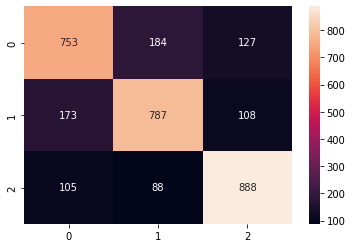

In [252]:

print(rf_model2.score(val_X, val_y))
results_cvs = cross_val_score(rf_model2, X, y, cv=StratifiedKFold(shuffle = True))
print(results_cvs)
print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [35]:
accuracy_score(val_y, y_pred)

0.7619047619047619

In [43]:
rf_model2.score(val_X, val_y)

0.7039337474120083

1    1049
2    1039
0     998
Name: code_prim_fuel_transf, dtype: int64


<AxesSubplot:>

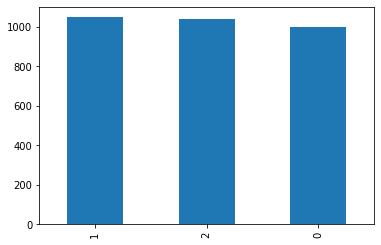

In [41]:
print(val_y.value_counts())
val_y.value_counts().plot.bar()

# XGBOOST

In [253]:
xgbclass_model_1 = XGBClassifier(random_state=0)
xgbclass_model_1.fit(train_X, train_y)
# xgbclass_model_1.fit(train_X_scaled_pca, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

0.755
[0.758 0.763 0.756 0.755 0.746]
Mean: 0.756, Standard Deviation: 0.006


<AxesSubplot:>

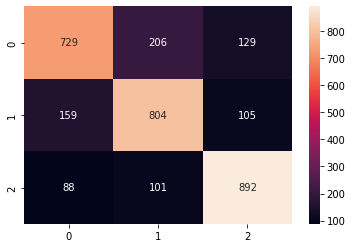

In [254]:
y_pred = xgbclass_model_1.predict(val_X)
print(np.around(xgbclass_model_1.score(val_X, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(xgbclass_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [48]:
# val_y.index.tolist()
# val_y.tolist()
# new_df = pd.DataFrame({"indice": val_y.index.tolist(), "valor": val_y.tolist(), "prediccion":y_pred})
# new_df.set_index('indice', inplace= True)
# df_power_plants_raw = pd.read_csv(dir_data_raw/"global_power_plant_database.csv", usecols=['primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3'], engine='python')


In [49]:
# new_df.head()

,valor,prediccion
indice,,
14440,1,1
25028,0,0
31258,1,1
1773,0,0
2817,2,2


In [50]:
# df_power_plants_raw.head()

,primary_fuel,other_fuel1,other_fuel2,other_fuel3
0,Hydro,NaN,NaN,NaN
1,Solar,NaN,NaN,NaN
2,Solar,NaN,NaN,NaN
3,Hydro,NaN,NaN,NaN
4,Hydro,NaN,NaN,NaN


In [ ]:
# df_power_plants_raw = df_power_plants_raw.join(new_df)

In [ ]:

df_power_plants_raw[['primary_fuel', 'other_fuel1', 'valor', 'prediccion']].value_counts()

In [49]:
param_grid = {
                'n_estimators': [5,10,50,100,500,1000],
                'learning_rate': [0.01,0.05,0.1,0.2],
                'max_depth': [2,3,4],
            }

In [50]:
xgb_grid = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)

In [ ]:
xgb_grid.fit(train_X, train_y)

In [36]:
xgb_grid.best_params_

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}

In [37]:
xgb_grid.score(val_X, val_y)

0.7432712215320911

In [51]:
xgbclass_model_2 = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4)
# xgbclass_model_2 = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4, early_stopping_rounds=5)
xgbclass_model_2.fit(train_X, train_y, 
             eval_set=[(val_X, val_y)], 
             verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

0.7705767984445885
[0.52883992 0.51215559 0.50923825 0.5452188  0.62171799]
Mean: 0.5434341108640369, Standard Deviation: 0.04121224073568436


<AxesSubplot:>

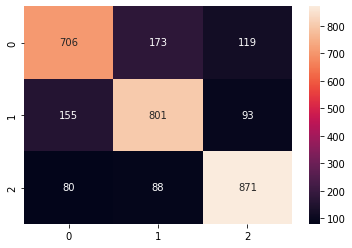

In [52]:
y_pred = xgbclass_model_2.predict(val_X)
print(xgbclass_model_2.score(val_X, val_y))
results_cvs = cross_val_score(xgbclass_model_2, X, y, cv=StratifiedKFold(shuffle = True))
print(results_cvs)
print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# KNN

5


<AxesSubplot:>

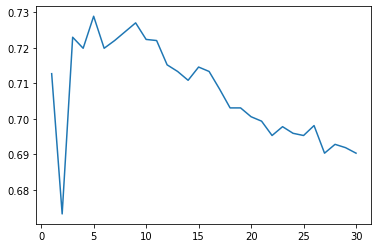

In [255]:
candidate_n_neighbors = np.arange(1,31)
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


# results = {n: get_accuracy_knn(n, train_X_scaled_pca, val_X_scaled_pca, train_y, val_y) for n in candidate_n_neighbors}
results = {n: get_accuracy_knn(n, train_X, val_X, train_y, val_y) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [256]:
knn_model_1 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_1.fit(train_X, train_y)

KNeighborsClassifier()

0.7289137877373172
[0.72237784 0.72517896 0.71086212 0.73785803 0.72447073]
Mean: 0.7241495380496186, Standard Deviation: 0.008588131544388792


<AxesSubplot:>

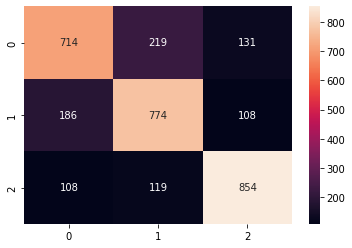

In [257]:
y_pred = knn_model_1.predict(val_X)
print(knn_model_1.score(val_X, val_y))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(knn_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(results_cvs)
print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [258]:
# train_X_normalized = stats.boxcox(train_X)
x = train_X.values #returns a numpy array
min_max_scaler = MinMaxScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
train_X_scaled = pd.DataFrame(x_scaled, index=train_X.index, columns=train_X.columns)

x = val_X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
val_X_scaled = pd.DataFrame(x_scaled, index=val_X.index, columns=val_X.columns)

x = X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)


In [259]:
train_X_scaled

,autumn_ALLSKY_SFC_SW_DWN_2012,autumn_ALLSKY_SFC_SW_DWN_2013,autumn_ALLSKY_SFC_SW_DWN_2014,autumn_ALLSKY_SFC_SW_DWN_2015,autumn_ALLSKY_SFC_SW_DWN_2016,autumn_ALLSKY_SFC_SW_DWN_2017,autumn_ALLSKY_SFC_SW_DWN_2018,autumn_ALLSKY_SFC_SW_DWN_2019,autumn_CLRSKY_SFC_SW_DWN_2012,autumn_CLRSKY_SFC_SW_DWN_2013,...,winter_WS50M_MAX_AVG_2018,winter_WS50M_MAX_AVG_2019,winter_WS50M_MIN_AVG_2012,winter_WS50M_MIN_AVG_2013,winter_WS50M_MIN_AVG_2014,winter_WS50M_MIN_AVG_2015,winter_WS50M_MIN_AVG_2016,winter_WS50M_MIN_AVG_2017,winter_WS50M_MIN_AVG_2018,winter_WS50M_MIN_AVG_2019
index,,,,,,,,,,,,,,,,,,,,,
16220,-0.935618,-0.974508,-0.943365,-0.982496,-0.899734,-0.871812,-1.050597,-0.874147,-1.068514,-1.062442,...,1.955179,1.504516,1.178075,1.246178,0.741405,1.002220,0.774483,0.539970,0.707241,1.012519
24795,0.678409,0.798862,0.699357,0.654043,0.748078,0.443642,0.485612,0.531137,0.848170,0.850069,...,-1.483353,-1.495198,-0.994602,-0.882302,-0.802875,-0.982306,-0.900285,-0.886026,-0.867740,-0.969476
24842,0.920852,1.060536,1.175109,1.354913,1.267985,1.106603,1.121532,1.160101,0.921778,0.946558,...,0.087245,-0.051292,-1.117497,-0.745828,-0.644549,-0.765058,-0.792468,-0.948973,-0.790486,-0.756949
10955,-1.562918,-1.579187,-1.541502,-1.573910,-1.452459,-1.519071,-1.502529,-1.564209,-1.527478,-1.516087,...,1.482723,1.295149,0.702730,1.086082,1.671870,1.109624,1.481287,1.125864,1.432431,1.222658
12704,-1.556137,-1.611012,-1.617347,-1.589799,-1.599277,-1.620260,-1.554331,-1.591165,-1.510159,-1.507446,...,0.805961,1.109246,1.034312,0.713401,0.329759,0.704419,0.755315,0.941864,0.879193,1.182063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28136,1.531199,1.642230,1.590530,1.377864,1.471803,1.546250,1.603830,1.469191,1.162806,1.188502,...,0.818731,0.966661,0.002464,0.671409,0.492956,0.233308,0.436654,0.142919,0.380782,0.525378
7329,-0.906796,-0.914394,-0.867521,-0.940126,-0.948097,-0.760155,-0.741569,-0.827424,-1.140678,-1.173333,...,1.116068,0.955832,0.011739,-0.194680,-0.284055,0.072202,0.331232,0.075130,0.368321,-0.009522
21432,-0.705043,-0.751732,-0.860626,-0.888929,-0.842734,-0.667690,-0.963069,-0.773513,-0.826042,-0.820498,...,-1.663944,-1.740661,-1.539511,-1.661783,-1.733340,-1.719486,-1.765223,-1.571182,-1.635294,-1.566462


In [260]:
def axis_calculation(total_columns_df, grid_columns):
    rows = int(total_columns_df / grid_columns)
    if( total_columns_df % grid_columns) > 0:
        rows += 1

    return (rows, grid_columns)
print(axis_calculation(30, 4))

(8, 4)


In [261]:

# # plt.figure(figsize=(200,200))
# grid_columns = 5
# result_axis = axis_calculation(len(train_X_scaled.columns), grid_columns)
# fig, axs = plt.subplots(result_axis[0],result_axis[1], figsize=(30,20))
# fig.subplots_adjust(hspace=.5)

# aux_cont = 0
# aux_cont_2 = 0
# # fig.figsize=(30,30)
# for col in train_X_scaled.columns:
# # #     # print(col)
#     sns.kdeplot(data=train_X_scaled, x=col, shade=True, ax=axs[aux_cont_2, aux_cont] )
#     # axs[aux_cont_2, aux_cont].set_xlabel('Participation Rate')
#     # axs[aux_cont_2, aux_cont].set_ylabel('Frequency')
#     # axs[aux_cont_2, aux_cont].set_title("sasa")
#     axs[aux_cont_2, aux_cont].set_xticklabels([])
#     aux_cont += 1
#     if aux_cont >= grid_columns:
#         aux_cont_2 +=1
#         aux_cont = 0

In [262]:
# train_X_scaled.hist(bins=100, xlabelsize=8, ylabelsize=10, figsize=(30,20))


In [263]:
# WITHOUT SCALING OR NORMALIZING
# train_X.hist(bins=100, xlabelsize=8, ylabelsize=10, figsize=(30,20))

5


<AxesSubplot:>

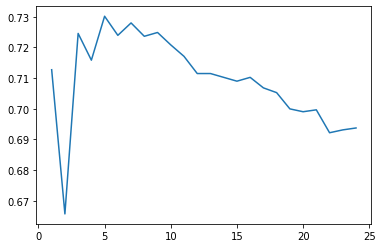

In [264]:
candidate_n_neighbors = np.arange(1,25)
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


results = {n: get_accuracy_knn(n, train_X_scaled, val_X_scaled, train_y, val_y) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [146]:
knn_model_2 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_2.fit(train_X_scaled, train_y)

KNeighborsClassifier(n_neighbors=4)

In [147]:
knn_model_2.score(val_X_scaled, val_y)

0.7329876863253403

0.733
[0.705 0.721 0.697 0.712 0.721]
Mean: 0.711, Standard Deviation: 0.009


<AxesSubplot:>

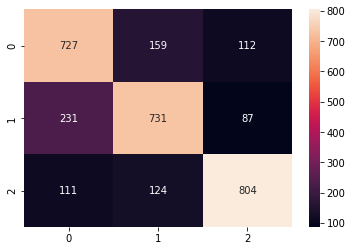

In [153]:
y_pred = knn_model_2.predict(val_X_scaled)
print(np.around(knn_model_2.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(knn_model_2, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# NAIVE BAYES

0.527
[0.509 0.539 0.517 0.528 0.521]
Mean: 0.523, Standard Deviation: 0.01


<AxesSubplot:>

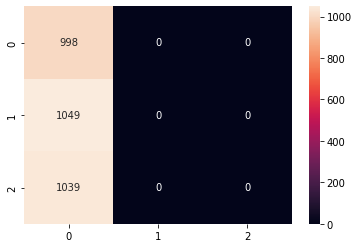

In [156]:
nb_model_1 = GaussianNB()

#Entreno el modelo
nb_model_1.fit(train_X, train_y)

#Realizo una predicción
y_pred = nb_model_1.predict(val_X_scaled)
print(np.around(nb_model_1.score(val_X, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(nb_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

0.528
[0.52  0.532 0.512 0.54  0.512]
Mean: 0.523, Standard Deviation: 0.011


<AxesSubplot:>

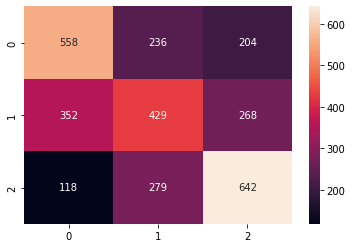

In [157]:
nb_model_2 = GaussianNB()
nb_model_2.fit(train_X_scaled, train_y)


y_pred = nb_model_2.predict(val_X_scaled)
print(np.around(nb_model_2.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(nb_model_2, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# SVM

In [159]:
svm_model_1 = SVC(random_state=22)
svm_model_1.fit(train_X_scaled, train_y)

SVC(random_state=22)

0.695
[0.682 0.681 0.69  0.679 0.695]
Mean: 0.686, Standard Deviation: 0.006


<AxesSubplot:>

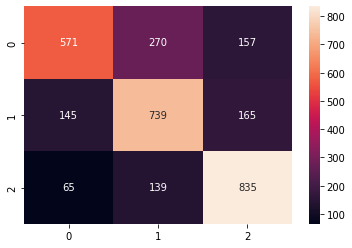

In [160]:
y_pred = svm_model_1.predict(val_X_scaled)
print(np.around(svm_model_1.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(svm_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [87]:
param_grid = {
                'C': [0.5, 1, 10, 100], # NOTE: values for C must be > 0
                'gamma': ['scale', 1, .1, .01, .001, .0001],
                'kernel': ['rbf'] # Some linear fittings last to 7/8 mins. Not recommended at all
            }
# svm_grid = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
svm_grid = RandomizedSearchCV(estimator = SVC(), param_distributions = param_grid, cv=5, verbose = 2, n_jobs=4)

In [ ]:
svm_grid.fit(train_X_scaled, train_y)

In [89]:
svm_grid.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 100}

In [90]:
svm_model_2 = SVC(C= 100, gamma= 1, kernel='rbf', random_state=22)
svm_model_2.fit(train_X_scaled, train_y)

SVC(C=100, gamma=1, random_state=22)

In [91]:
y_pred = svm_model_2.predict(val_X_scaled)

In [92]:
svm_model_2.score(val_X_scaled, val_y)

0.7556935817805382

<AxesSubplot:>

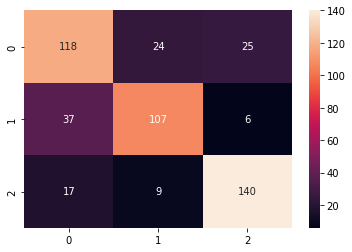

In [93]:
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# PCA

In [161]:
pca = PCA(n_components=3)
pca.fit(train_X_scaled)

PCA(n_components=3)

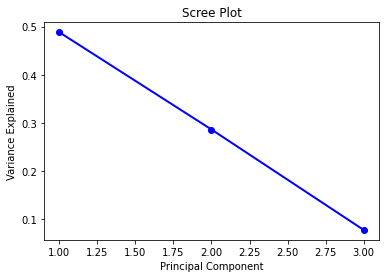

In [162]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [163]:
train_X_scaled_pca = pca.transform(train_X_scaled)
val_X_scaled_pca = pca.transform(val_X_scaled)

In [164]:
train_pc1_coords = train_X_scaled_pca[:,0]
train_pc2_coords = train_X_scaled_pca[:,1]
train_pc3_coords = train_X_scaled_pca[:,2]

# LOGISTIC REGRESSION

/home/tomas/renewable_power_plants/renewable_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6659105638366818


<AxesSubplot:>

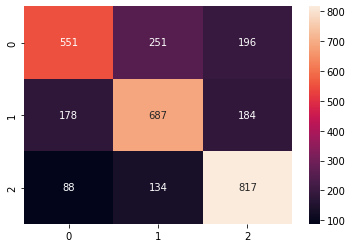

In [166]:
logistic_model_1 = LogisticRegression(random_state=22)
logistic_model_1.fit(train_X_scaled, train_y)
y_pred = logistic_model_1.predict(val_X_scaled)
print(logistic_model_1.score(val_X_scaled, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# LDA

In [167]:
lda = LDA(n_components = 2)
train_X_scaled_lda = lda.fit_transform(train_X_scaled, train_y)
val_X_scaled_lda = lda.transform(val_X_scaled)

0.6843810758263124


<AxesSubplot:>

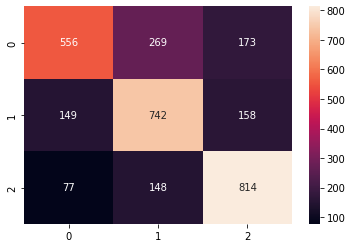

In [168]:
lda.fit(train_X_scaled_lda, train_y)
y_pred = lda.predict(val_X_scaled_lda)
print(lda.score(val_X_scaled_lda, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# NEURAL NETWORK

0.6243523316062176


<AxesSubplot:>

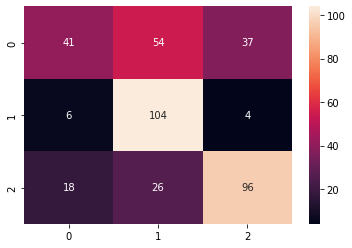

In [80]:
nn_model_1 = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
nn_model_1.fit(train_X, train_y)
y_pred = nn_model_1.predict(val_X)
print(nn_model_1.score(val_X, val_y))
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# TEST PREDICTION

In [271]:
df_to_predict = pd.read_csv(dir_data_external/"data_predict.csv", index_col=['index'])
df_to_predict.drop(columns=['latitude','longitude'], inplace=True)

In [272]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None

In [273]:
# print(df_to_predict.columns)
# print(df_to_predict.columns.tolist())

In [274]:
columns_delete = df_to_predict.columns.str.contains('ALLSKY_KT') | df_to_predict.columns.str.contains('ANN') | df_to_predict.columns.str.contains('autumn_CLRSKY_SFC_SW_DWN_2019')
df_to_predict = df_to_predict.loc[:,~columns_delete]
# df_to_predict = df_to_predict.loc[:,~COLUMNS_TO_DELETE]

In [275]:
y_predicted_test = xgbclass_model_1.predict(df_to_predict)
print(y_predicted_test)

[1]


In [85]:
df_target_equivalent

,primary_fuel_transformed,code_prim_fuel_transf
index,,
24713,Solar,1
24717,Other,0
24749,Wind,2


# BAGGING CLASSIFIER

In [ ]:
bag_model_1 = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=50)
bag_model_1.fit(train_X_scaled, train_y)
y_pred = bag_model_1.predict(val_X_scaled)
# print(bag_model_1.score(val_X_scaled, val_y))

# results_cvs = cross_val_score(bag_model_1, train_X_scaled, train_y, cv=5)
# print(results_cvs)
# print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
# confusion_matrix_return = confusion_matrix(val_y, y_pred)
# sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')


print(np.around(bag_model_1.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(bag_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [87]:
classifier = {
        'KNeighbors': KNeighborsClassifier(n_neighbors=9),
        'DecisionTree': DecisionTreeClassifier(max_leaf_nodes=50),
        'XGBClassifier': XGBClassifier()
    }

for name, estimator in classifier.items():
    bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=5).fit(train_X_scaled, train_y)
    
    bag_pred = bag_class.predict(val_X_scaled)

    print(f'Accuracy Bagging with {name}: {accuracy_score(bag_pred, val_y)}')
    print('')
    print(f'Mean: {cross_val_score(bag_class, X, y, cv=5).mean()}, Standard Deviation: {cross_val_score(tree_model, X, y, cv=5).std()}')
    print('')

Accuracy Bagging with KNeighbors: 0.7305699481865285

Mean: 0.7181347150259068, Standard Deviation: 0.017601334457474662

Accuracy Bagging with DecisionTree: 0.7202072538860104

Mean: 0.7383419689119171, Standard Deviation: 0.017601334457474662

Accuracy Bagging with XGBClassifier: 0.7331606217616581

Mean: 0.7476683937823834, Standard Deviation: 0.017601334457474662



# VOTING CLASSIFIER

0.733
[0.744 0.732 0.743 0.757 0.747]
Mean: 0.744, Standard Deviation: 0.008


<AxesSubplot:>

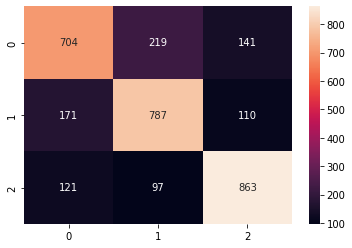

In [267]:


votclass_model_1 = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=9)), ('dt', DecisionTreeClassifier(max_leaf_nodes=50)), ('xgb', XGBClassifier())], voting='hard')
votclass_model_1.fit(train_X_scaled, train_y)

y_pred = votclass_model_1.predict(val_X_scaled)

print(np.around(votclass_model_1.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(votclass_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# ADABOOST

0.633
[0.657 0.647 0.662 0.648 0.653]
Mean: 0.654, Standard Deviation: 0.006


<AxesSubplot:>

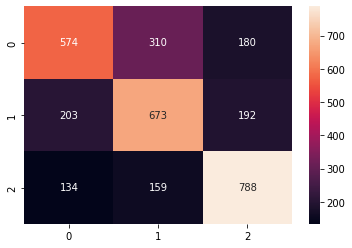

In [269]:
adaBoost_model_1 = AdaBoostClassifier(n_estimators=100)
adaBoost_model_1.fit(train_X_scaled, train_y)

y_pred = adaBoost_model_1.predict(val_X_scaled)

print(np.around(adaBoost_model_1.score(val_X_scaled, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(adaBoost_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# GRADIENT TREE BOOSTING

In [270]:
gradboost_model_1 = GradientBoostingClassifier(n_estimators=50)
gradboost_model_1.fit(train_X, train_y)
y_pred = gradboost_model_1.predict(val_X)
print(np.around(gradboost_model_1.score(val_X, val_y),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(gradboost_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(val_y, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

0.68


KeyboardInterrupt: 